In [1]:
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
from pandas import Series
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-dark')
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [2]:
df = pd.read_csv('international-airline-passengers.csv')

In [3]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.columns = ['year' , 'passengers']

In [5]:
df.head()

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
df.describe(include='O')

,year
count,144
unique,144
top,1953-01
freq,1


In [8]:
df.shape

(144, 2)

In [9]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-01
Time period end: 1960-12


### DATA PRE PROCESSING AND VISUALIZATIONS

In [10]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [11]:
y = df.set_index('year')

In [12]:
y.isnull().sum()

passengers    0
dtype: int64

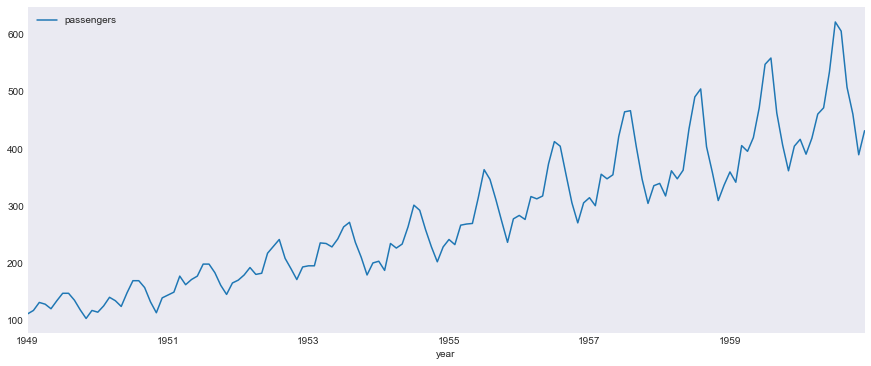

In [13]:
y.plot(figsize=(15, 6))
plt.show()

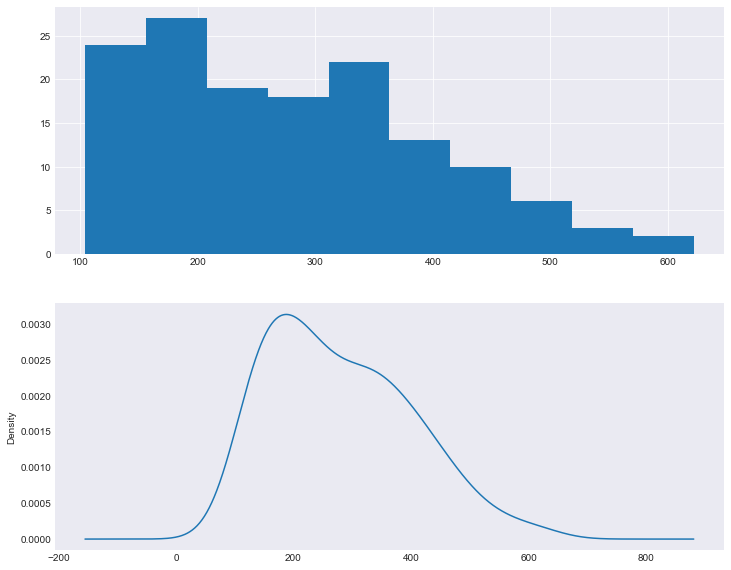

In [14]:
pyplot.figure(1, figsize = (12,10))
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

From above graphs we can infer that:
1. The distribution is not a normal distribution.

2. The distribution is left shifted.


### Pre Processing

In [15]:
dataset = df['passengers']
dataset = np.array(dataset).reshape(-1,1)
dataset = dataset.astype("float32")
dataset.shape

(144, 1)

In [16]:
#Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [17]:
#Spli the data
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [18]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)

In [19]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### LSTM model for regression

In [20]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=80, batch_size=1, verbose=2)

Epoch 1/80
94/94 - 0s - loss: 0.0521
Epoch 2/80
94/94 - 0s - loss: 0.0268
Epoch 3/80
94/94 - 0s - loss: 0.0204
Epoch 4/80
94/94 - 0s - loss: 0.0182
Epoch 5/80
94/94 - 0s - loss: 0.0169
Epoch 6/80
94/94 - 0s - loss: 0.0159
Epoch 7/80
94/94 - 0s - loss: 0.0148
Epoch 8/80
94/94 - 0s - loss: 0.0136
Epoch 9/80
94/94 - 0s - loss: 0.0124
Epoch 10/80
94/94 - 0s - loss: 0.0111
Epoch 11/80
94/94 - 0s - loss: 0.0099
Epoch 12/80
94/94 - 0s - loss: 0.0086
Epoch 13/80
94/94 - 0s - loss: 0.0074
Epoch 14/80
94/94 - 0s - loss: 0.0063
Epoch 15/80
94/94 - 0s - loss: 0.0053
Epoch 16/80
94/94 - 0s - loss: 0.0044
Epoch 17/80
94/94 - 0s - loss: 0.0038
Epoch 18/80
94/94 - 0s - loss: 0.0032
Epoch 19/80
94/94 - 0s - loss: 0.0028
Epoch 20/80
94/94 - 0s - loss: 0.0025
Epoch 21/80
94/94 - 0s - loss: 0.0023
Epoch 22/80
94/94 - 0s - loss: 0.0022
Epoch 23/80
94/94 - 0s - loss: 0.0021
Epoch 24/80
94/94 - 0s - loss: 0.0021
Epoch 25/80
94/94 - 0s - loss: 0.0020
Epoch 26/80
94/94 - 0s - loss: 0.0020
Epoch 27/80
94/94 - 0

In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [22]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.68 RMSE
Test Score: 50.26 RMSE


In [23]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

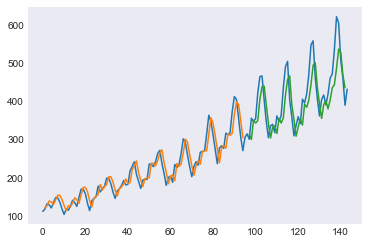

In [24]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### LSTM for Regression using Window method

In [25]:
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [26]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
91/91 - 0s - loss: 0.0384
Epoch 2/100
91/91 - 0s - loss: 0.0144
Epoch 3/100
91/91 - 0s - loss: 0.0098
Epoch 4/100
91/91 - 0s - loss: 0.0083
Epoch 5/100
91/91 - 0s - loss: 0.0071
Epoch 6/100
91/91 - 0s - loss: 0.0061
Epoch 7/100
91/91 - 0s - loss: 0.0053
Epoch 8/100
91/91 - 0s - loss: 0.0046
Epoch 9/100
91/91 - 0s - loss: 0.0042
Epoch 10/100
91/91 - 0s - loss: 0.0039
Epoch 11/100
91/91 - 0s - loss: 0.0037
Epoch 12/100
91/91 - 0s - loss: 0.0036
Epoch 13/100
91/91 - 0s - loss: 0.0035
Epoch 14/100
91/91 - 0s - loss: 0.0034
Epoch 15/100
91/91 - 0s - loss: 0.0033
Epoch 16/100
91/91 - 0s - loss: 0.0033
Epoch 17/100
91/91 - 0s - loss: 0.0032
Epoch 18/100
91/91 - 0s - loss: 0.0032
Epoch 19/100
91/91 - 0s - loss: 0.0032
Epoch 20/100
91/91 - 0s - loss: 0.0031
Epoch 21/100
91/91 - 0s - loss: 0.0030
Epoch 22/100
91/91 - 0s - loss: 0.0030
Epoch 23/100
91/91 - 0s - loss: 0.0031
Epoch 24/100
91/91 - 0s - loss: 0.0030
Epoch 25/100
91/91 - 0s - loss: 0.0029
Epoch 26/100
91/91 - 0s - loss: 0.

In [27]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [28]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.70 RMSE
Test Score: 66.60 RMSE


In [29]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

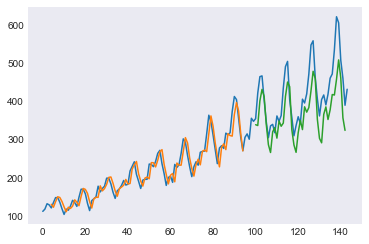

In [30]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()